In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import sys

sys.path.insert(0, "C:/workspace/data-science//libs")
from big_numbers import expand_to_18_decimals, expand_to_18_decimals_object, contract_18_decimals_to_float

In [2]:
position_changes_df = pd.read_csv('position_changes_pure_df.csv')
positions_df = pd.read_csv('positions_pure_df.csv')
amm_positions_df = pd.read_csv('amm_positions_pure_df.csv')
liquidations_df = pd.read_csv('liquidation_pure_df.csv')

C:\Users\Zbook\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Adapting the data to the human-readable format

In [5]:
%%time

# transform all numerical data
position_changes_df['margin'] = position_changes_df['margin'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['position_notional'] = position_changes_df['position_notional'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['exchanged_position_size'] = position_changes_df['exchanged_position_size'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['fee'] = position_changes_df['fee'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['position_size_after'] = position_changes_df['position_size_after'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['realized_pnl'] = position_changes_df['realized_pnl'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['unrealized_pnl_after'] = position_changes_df['unrealized_pnl_after'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['bad_debt'] = position_changes_df['bad_debt'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['liquidation_penalty'] = position_changes_df['liquidation_penalty'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['spot_price'] = position_changes_df['spot_price'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['funding_payment'] = position_changes_df['funding_payment'].apply(lambda x: contract_18_decimals_to_float(x))

# make sure that there is a datetime info
position_changes_df['timestamp'] = pd.to_datetime(position_changes_df['timestamp'])

In [6]:
%%time
replacement_map = {'0x0f346e19f01471c02485df1758cfd3d624e399b4': 'BTC/USDC',
                      '0x8d22f1a9dce724d8c1b4c688d75f17a2fe2d32df': 'ETH/USDC',
                      '0xd41025350582674144102b74b8248550580bb869': 'YFI/USDC',
                      '0x6de775aabeeede8efdb1a257198d56a3ac18c2fd': 'DOT/USDC',
                      '0xb397389b61cbf3920d297b4ea1847996eb2ac8e8': 'SNX/USDC',
                      '0x80daf8abd5a6ba182033b6464e3e39a0155dcc10': 'LINK/USDC',
                      '0x16a7ecf2c27cb367df36d39e389e66b42000e0df': 'AAVE/USDC',
                      '0xf559668108ff57745d5e3077b0a7dd92ffc6300c': 'SUSHI/USDC',
                      '0x33fbaefb2dcc3b7e0b80afbb4377c2eb64af0a3a': 'COMP/USDC',
                      '0x922f28072babe6ea0c0c25ccd367fda0748a5ec7': 'REN/USDC',
                      '0xfcae57db10356fcf76b6476b21ac14c504a45128': 'PERP/USDC',
                      '0xeac6cee594edd353351babc145c624849bb70b11': 'UNI/USDC',
                      '0xab08ff2c726f2f333802630ee19f4146385cc343': 'CRV/USDC',
                      '0xb48f7accc03a3c64114170291f352b37eea26c0b': 'MKR/USDC',
                      '0x7b479a0a816ca33f8eb5a3312d1705a34d2d4c82': 'CREAM/USDC',
                      '0x187c938543f2bde09fe39034fe3ff797a3d35ca0': 'GRT/USDC',
                      '0x26789518695b56e16f14008c35dc1b281bd5fc0e': 'ALPHA/USDC',
                      '0xf9e30f08a738620bc2331f728de4dac7937888d3': 'wtf?',
                      '0x838b322610bd99a449091d3bf3fba60d794909a9': 'FTT/USDC'}

position_changes_df['amm_name'] = position_changes_df['amm']
position_changes_df['amm_name'].replace(replacement_map, inplace=True)
position_changes_df

Wall time: 4.97 s


,Unnamed: 0,id,trader,amm,margin,position_notional,exchanged_position_size,fee,position_size_after,realized_pnl,unrealized_pnl_after,bad_debt,liquidation_penalty,spot_price,funding_payment,block_number,timestamp,amm_name
0,0,0x06d54c4ad4bfff493051ef548557f4fa0c76fb2dd678...,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,5552.445854,16657.337561,0.872710,16.657338,0.872710,0.000000e+00,0.000000e+00,0.0,0.0,19120.287600,0.000000,13508290,2020-12-14 03:16:05,BTC/USDC
1,1,0x0e824c5f4e27ba5f29b8791e25e76e732783b25bba44...,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x8d22f1a9dce724d8c1b4c688d75f17a2fe2d32df,6816.007869,20448.023608,34.908392,20.448024,34.908392,0.000000e+00,0.000000e+00,0.0,0.0,586.786590,0.000000,13508290,2020-12-14 03:16:05,ETH/USDC
2,2,0xeebbca404104c295253184426d13273fcafcb7886773...,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x8d22f1a9dce724d8c1b4c688d75f17a2fe2d32df,13632.015738,20448.023608,34.786745,20.448024,69.695137,0.000000e+00,7.138055e+01,0.0,0.0,588.836755,0.000000,13508290,2020-12-14 03:16:05,ETH/USDC
3,3,0xe9d804889de5a27a356777a588d6c018e55fa1cae61c...,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,11114.600000,16686.462439,0.871187,16.686462,1.743896,0.000000e+00,5.824967e+01,0.0,0.0,19187.208607,0.000000,13508954,2020-12-14 04:11:45,BTC/USDC
4,4,0xea81e16520eae51395b4627365487daa2013df876ef3...,0x1a48776f436bcdaa16845a378666cf4ba131eb0f,0x0f346e19f01471c02485df1758cfd3d624e399b4,0.000000,33343.800000,-1.743896,33.343800,0.000000,-1.782200e-14,0.000000e+00,0.0,0.0,19053.600000,0.000000,13509011,2020-12-14 04:16:30,BTC/USDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9341964,9341964,0xd6b80d8c63a2e68138c6b7f7373dcdc279d7b977b366...,0xce7e86725fa9ef1f5cd0f266bf5d48af1686f445,0x8d22f1a9dce724d8c1b4c688d75f17a2fe2d32df,3978.375077,1557.933590,-0.599936,1.557934,1.500108,2.365634e+00,5.915138e+00,0.0,0.0,2596.667440,0.000000,21102610,2022-03-14 09:46:50,ETH/USDC
9341965,9341965,0xfcbb8bd63053c16269c4a1557a6fd42e3ddd92998c6b...,0x9d9250586e0443b49cbc975aa51dfb739c8ec50d,0xab08ff2c726f2f333802630ee19f4146385cc343,25461.339595,2314.200313,1171.740513,2.314200,-11576.634820,-1.305977e+01,-1.290287e+02,0.0,0.0,1.975700,1.483261,21102627,2022-03-14 09:48:15,CRV/USDC
9341966,9341966,0x3430325ddfd0ae52500a6c7c6c36cfd8193f81a76aa5...,0x72dd2ce1b88f2cbcee606ec2ede14cf03563e08d,0x26789518695b56e16f14008c35dc1b281bd5fc0e,18127.454018,613.110965,2350.725652,0.613111,-92971.274248,4.709797e+00,1.862726e+02,0.0,0.0,0.260852,0.000000,21102629,2022-03-14 09:48:25,ALPHA/USDC
9341967,9341967,0x26460150a641bcc3ddba218653448d0e0d05968049b8...,0xc701072cd7396622fac184aa778d549a34b1545c,0xd41025350582674144102b74b8248550580bb869,0.000000,4002.836312,0.215159,4.002836,0.000000,-2.836312e+00,0.000000e+00,0.0,0.0,18621.705633,0.000000,21102631,2022-03-14 09:48:35,YFI/USDC


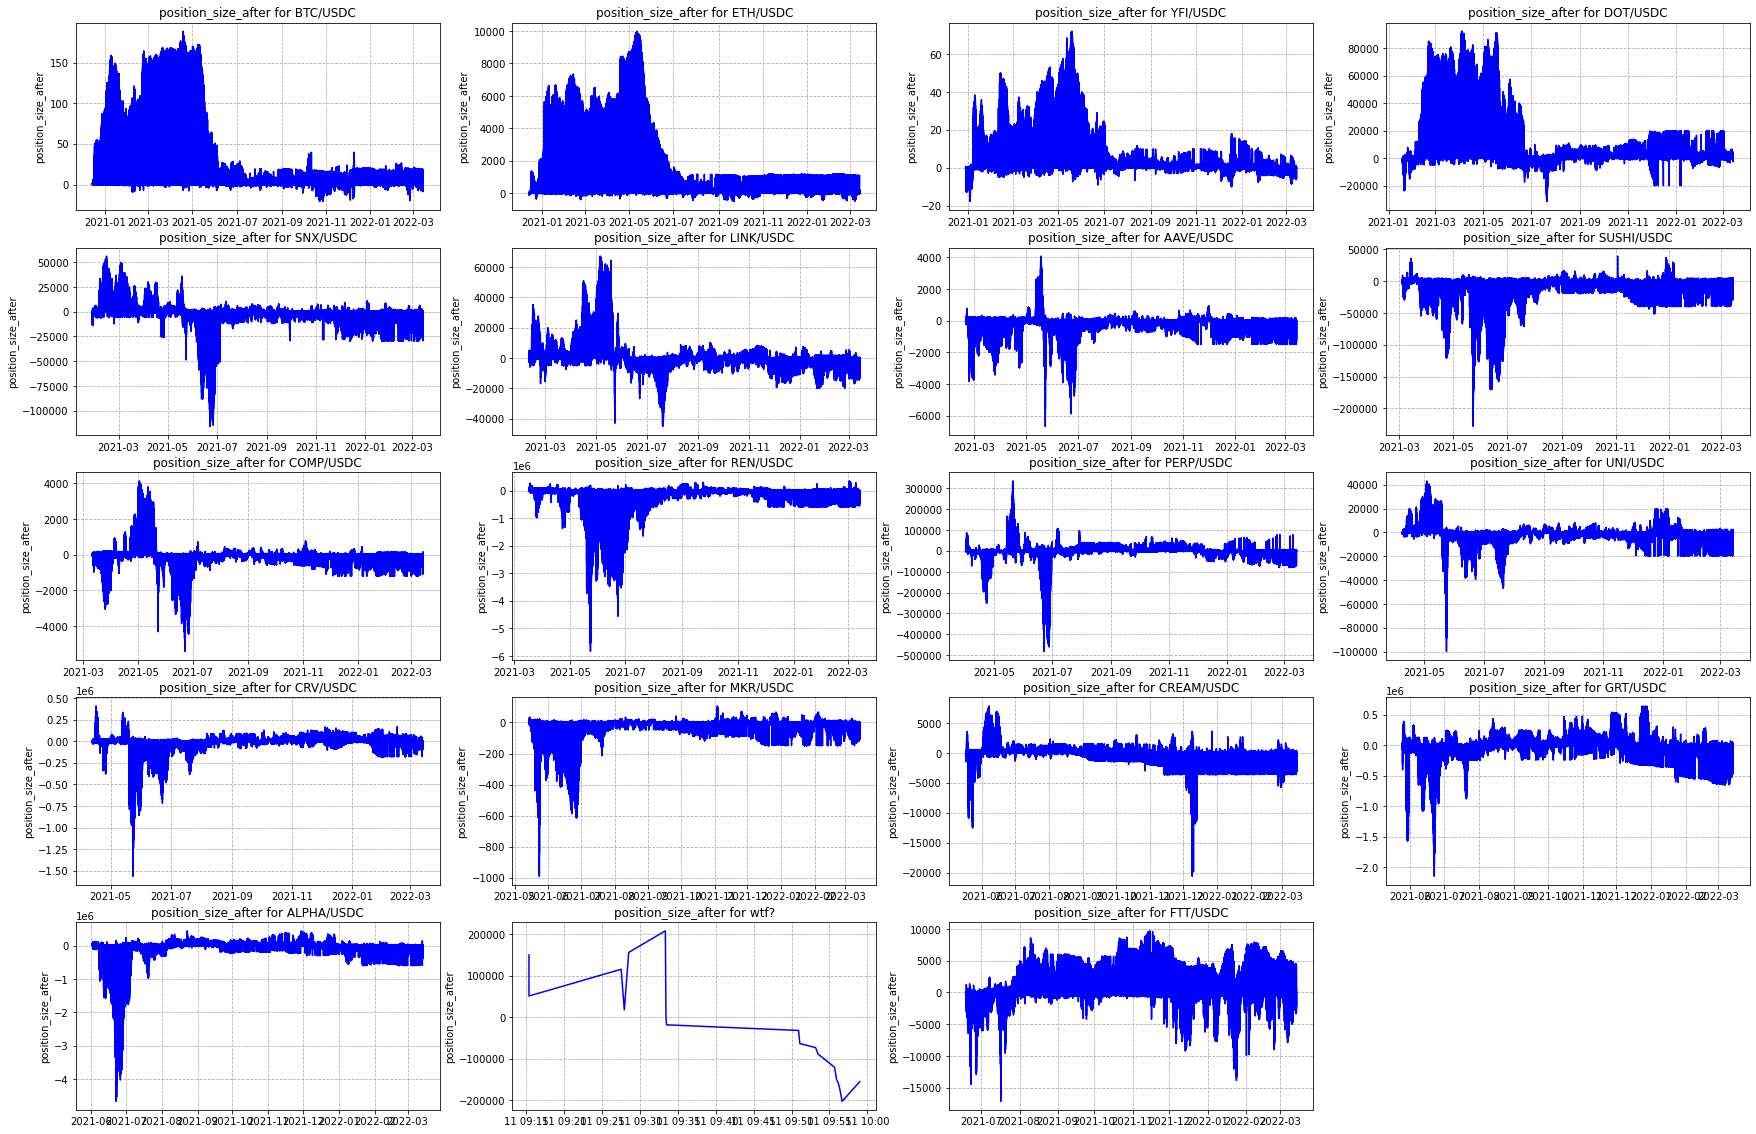

In [8]:
plt.figure(figsize=(30, 20))
index = 0

for amm_name in position_changes_df['amm_name'].unique():
    ax = plt.subplot(5, 4, index+1)
    ax.plot(position_changes_df[position_changes_df['amm_name'] == amm_name]['timestamp'], 
            position_changes_df[position_changes_df['amm_name'] == amm_name]['position_size_after'], color='b')
    ax.set_title('position_size_after for ' + amm_name)
    ax.set_ylabel('position_size_after')
    ax.grid(True, linestyle='--')
    index += 1
    
plt.show()